In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

from datetime import datetime
import glob
import rarfile
import os

import cv2

# Data loading

In [2]:
# !curl -L -k -o data.rar "https://drive.usercontent.google.com/download?id=1lJKLz3LsQmnAf9q5GGi6arEYBz-3CMhx&export=download&authuser=0&confirm=t&uuid=8b40c1cb-b956-4792-a0d5-8660e8e1777f&at=AENtkXYKKRITfP_6yrJGUvUvr7IH%3A1732475784414"

# if not os.path.exists("data/"):
#     os.makedirs("data/")

# try:
#     with rarfile.RarFile("data.rar") as rf:
#         rf.extractall(path="data/")
# except Exception as e:
#     print("Error:", e)

In [3]:
# maria
start_62 = "090652"
end_62 = "090842"
# random
start_71 = "092022"
end_71 = "092212"
# martyna
start_72 = "091752"
end_72 = "091942"
# test
start_t = "090532"
end_t = "090722"

# %%
path_out = "data_temp"
files = glob.glob(path_out + "/*")
files.sort()

dx = 5.106500953873407
dt = 0.0016


def load_df(start, end):
    start_idx = files.index(f"{path_out}\\{start}.npy")
    end_idx = files.index(f"{path_out}\\{end}.npy")

    data = []
    first_filename = files[start_idx]
    for file in files[start_idx : end_idx + 1]:
        data.append(np.load(file))
    data = np.concatenate(data)
    time_start = datetime.strptime(
        "2024-05-07 " + first_filename.split("\\")[-1].split(".")[0], "%Y-%m-%d %H%M%S"
    )
    index = pd.date_range(start=time_start, periods=len(data), freq=f"{dt}s")

    columns = np.arange(len(data[0])) * dx

    df = pd.DataFrame(data=data, index=index, columns=columns)
    return df


df62 = load_df(start_62, end_62)
df71 = load_df(start_71, end_71)
df72 = load_df(start_72, end_72)
df = load_df(start_t, end_t)

In [4]:
def set_axis(x, no_labels = 7)->tuple[np.array, np.array]:
    """Sets the x-axis positions and labels for a plot.

    Args:
        x (np.array): The x-axis data.
        no_labels (int, optional): The number of labels to display. Defaults to 7.

    Returns:
        tuple[np.array, np.array]: A tuple containing:
            - The positions of the labels on the x-axis.
            - The labels themselves.
    """
    nx = x.shape[0]
    step_x = int(nx / (no_labels - 1))
    x_positions = np.arange(0,nx,step_x)
    x_labels = x[::step_x]
    return x_positions, x_labels

In [5]:
def plot_image(img, a=6, b=9, lines=None, title="DataFrame Visualization", velocities=None):
    """
    Plots a DataFrame as an image with continuous coloring based on the range of values
    using normalization.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing the image data with numeric values.
    """
    # Normalize the data to the range [0, 1]
    norm = Normalize(vmin=img.min().min(), vmax=img.max().max())
    
    # Create the plot
    plt.figure(figsize=(a, b))
    plt.imshow(img, cmap='viridis', aspect='auto', norm=norm,  interpolation="none")
    
    if lines is not None:
        for i, line in enumerate(lines):
            x1, y1, x2, y2 = line[0]
            plt.plot([x1, x2], [y1, y2], color='red', linewidth=2)

            # Annotate velocity
            if velocities is not None:
                mid_x, mid_y = (x1 + x2) / 2, (y1 + y2) / 2
                plt.text(mid_x, mid_y, f"{velocities[i]:.2f} km/h", color="cyan", fontsize=10, ha="center", va="center")


    # plt.colorbar(label='Value')
    plt.title(title)
    if velocities is not None:
        plt.colorbar(label="Intensity")
        plt.xlabel("Columns (Space)")
        plt.ylabel("Rows (Time)")
        plt.axis("on")
    else:
        plt.axis('off')  # Turn off axis labels for better image representation
    # Display the plot
    plt.show()

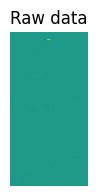

In [6]:
plot_image(df.values, a=1, b=2, title="Raw data")

In [7]:
# df = pd.DataFrame(data=data, index=index, columns=columns)
# df.shape

In [8]:
#RESIZING =>DECIMATION WITH LANCZOS INTERPOLATION❤️🦎
df = cv2.resize(df.values, (50, 1000), interpolation=cv2.INTER_LANCZOS4)
print(f"Shape of the resized df: {df.shape}")


Shape of the resized df: (1000, 50)


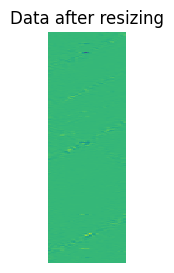

In [9]:
plot_image(df,a=1,b=3, title="Data after resizing")


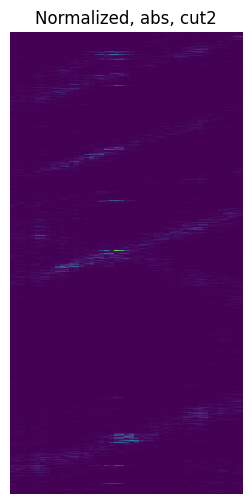

In [10]:
# df = pd.DataFrame(data=data, index=index, columns=columns)
df = pd.DataFrame(df)
df = df.iloc[:, 3:]  #DELETE FIRST 2 COLUMNS, -IT HAS NOISE, AND ITS 
#                   NOT THAT RELEVANT FOR DETECTION OF LINES❤️🦎

#ARITHMETIC OPERATIONS
df = np.abs(df)  #ABSOLUTELY NECESSARY  ❤️🦎

#NORMALIZE values to 0,255
normalized_image = cv2.normalize(df.values, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
df = pd.DataFrame(normalized_image)
plot_image(df,a=3, b=6, title="Normalized, abs, cut2")


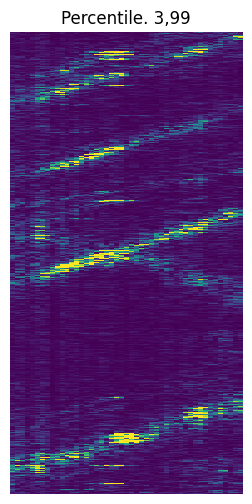

(1000, 47)


In [11]:

#CLIP PERCENTILES FOR OUTLIERS ❤️🦎 - CRUCIAL
low, high = np.percentile(df, [3,99]).astype(np.float32)
df[:] = df.apply(lambda col: np.where(((col < low)), 0, col))
df.clip(upper = high, inplace=True)

plot_image(df.values, a=3,b=6, title="Percentile. 3,99")
print(df.shape)
df_normalized = df


df_orginal = df  #NEEDED FOR FINAL VIS ❤️🦎

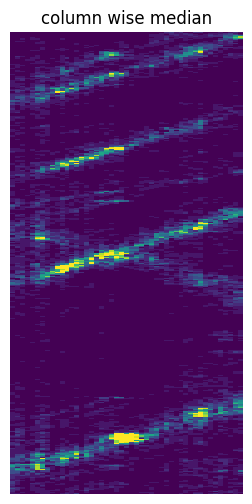

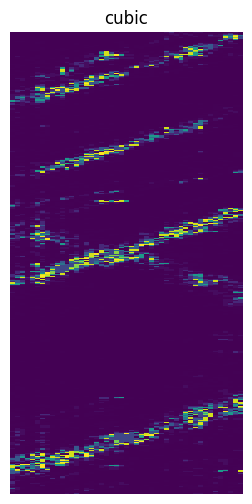

In [12]:

def column_wise_median_filter(df, kernel_size=5):
    """
    Applies a median filter to each column in the DataFrame.
    
    Parameters:
        df (pd.DataFrame): Input DataFrame.
        kernel_size (int): Size of the median filter window (must be odd).
    
    Returns:
        pd.DataFrame: Denoised DataFrame.
    """
    filtered_data = df.copy()
    
    for col in df.columns:
        filtered_data[col] = cv2.medianBlur(df[col].values.astype(np.uint8), kernel_size)
    
    return filtered_data

# Apply the median filter
df_denoised = column_wise_median_filter(df_normalized, kernel_size=5)

# Visualize the result
plot_image(df_denoised.values, a=3, b=6, title="column wise median")
df_squared = df_denoised **3
plot_image(df_squared.values, a=3, b=6, title="cubic")
# print(df_squared.max(axis=1))

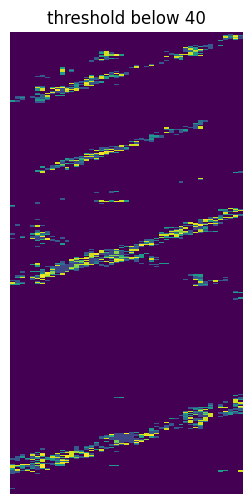

In [13]:
df_squared[:] = df_squared.apply(lambda col: np.where(((col < 40)), 0, col))
plot_image(df_squared.values,3, 6, title="threshold below 40")

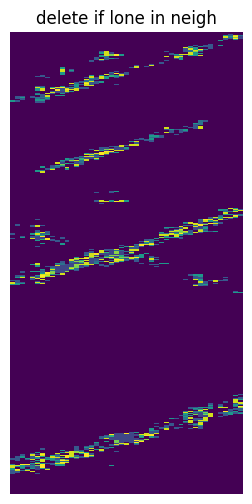

In [14]:
def set_pixel_zero_based_on_neighborhood(image, neighborhood_size=(50, 10), min_count=20):
   
    output_image = image.copy()
    h, w = image.shape
    nh, nw = neighborhood_size
    
    for y in range(h):
        for x in range(w):
            # Define the neighborhood boundaries
            y1 = max(y - nh // 2, 0)
            y2 = min(y + nh // 2 + 1, h)
            x1 = max(x - nw // 2, 0)
            x2 = min(x + nw // 2 + 1, w)
            
            # Extract the neighborhood
            neighborhood = image[y1:y2, x1:x2]
            
            # Count the number of non-zero pixels in the neighborhood
            if cv2.countNonZero(neighborhood) < min_count:
                output_image[y, x] = 0
    
    return output_image
denois = set_pixel_zero_based_on_neighborhood(df_squared.values)
plot_image(denois, 3, 6, title="delete if lone in neigh")
denois = pd.DataFrame(denois)

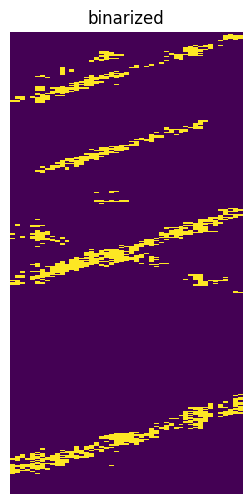

In [15]:
#BINARIZATION
df_binarized = (denois > 0).astype(int)
plot_image(df_binarized.values,a=3,b=6, title="binarized")

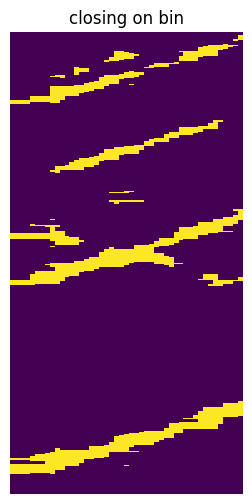

In [16]:
#CLOSING ON CANNY == CLOSING ON BINARIZED DF
    
kernel = np.ones((3, 2), np.uint8)

closed_bin = cv2.morphologyEx(df_binarized.values.astype(np.uint8), cv2.MORPH_CLOSE, kernel, iterations=3)
plot_image(closed_bin, 3, 6, title="closing on bin")

# edges_closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations=3)
# plot_image(edges_closed_bin, 3, 6, title="closing ")

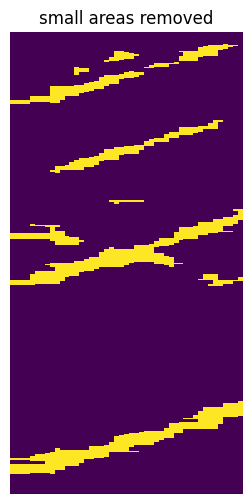

In [17]:
def remove_small_areas(binary_image, min_area=100):
    num_labels, labels = cv2.connectedComponents(binary_image)
    output_image = np.zeros_like(binary_image, dtype=np.uint8)
    
    for label in range(1, num_labels):
        region = (labels == label).astype(np.uint8)
        if cv2.countNonZero(region) >= min_area:
            output_image[region == 1] = 255
    
    return output_image

remove_small = remove_small_areas(closed_bin, 30)
plot_image(remove_small, 3,6,title="small areas removed")

<!-- -------
-------
------- -->

In [18]:
# def plot_connected_components(binary_image):
#     # Find connected components and their labels
#     num_labels, labels = cv2.connectedComponents(binary_image)

#     # Plot each connected component separately
#     for label in range(1, num_labels):  # Start from 1 to skip the background
#         region = (labels == label).astype(np.uint8) * 255  # Extract the region and scale to 255
#         plot_image(region, 1,2)
# plot_connected_components(remove_small)


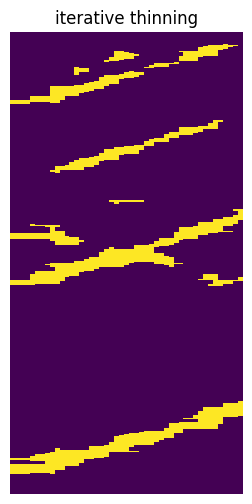

In [19]:
def erode_wide_lines(binary_image, min_line_width=5, kernel_size=3, iterations=1):
    num_labels, labels = cv2.connectedComponents(binary_image)
    mask = np.zeros_like(binary_image, dtype=np.uint8)
    
    for label in range(1, num_labels):
        region = (labels == label).astype(np.uint8)
        if cv2.countNonZero(region) >= min_line_width:
            mask[region == 1] = 1
    
    kernel = np.ones((5,3), np.uint8)
    eroded_image = cv2.erode(binary_image, kernel, iterations=iterations)
    result_image = np.where(mask == 1, eroded_image, binary_image)
    result_image = (result_image * 255).astype(np.uint8)
    
    return result_image

# Example usage
iterative_thinning = erode_wide_lines(remove_small, min_line_width=2500, kernel_size=3, iterations=2)
plot_image(iterative_thinning, 3, 6, title="iterative thinning")

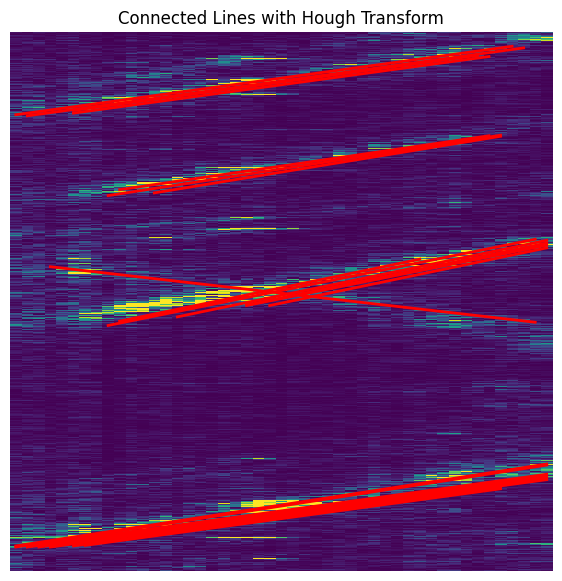

In [20]:
lines = cv2.HoughLinesP(iterative_thinning, rho=1, theta=np.pi / 180, threshold=5, minLineLength=100, maxLineGap=25)
plot_image(df_normalized.values, a=7, b= 7, lines = lines, title="Connected Lines with Hough Transform")


[[[0, 953, 46, 830]], [[8, 544, 46, 400]], [[8, 303, 42, 193]], [[0, 153, 44, 29]], [[3, 435, 45, 538]]]


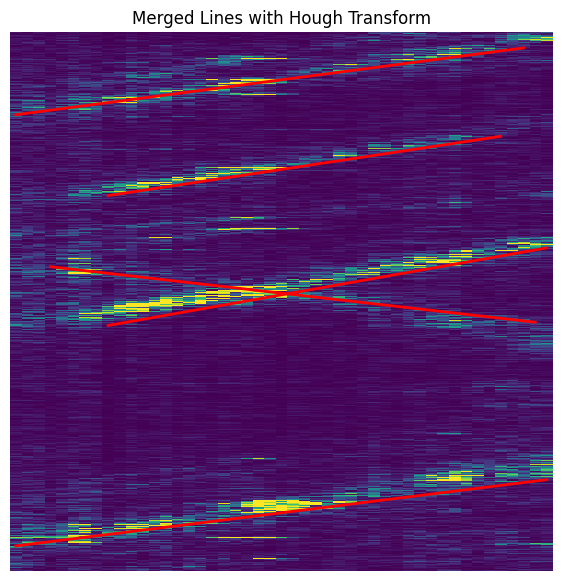

In [21]:
def merge_lines(lines, min_distance=30, max_angle_diff=25):
    """
    Groups lines that are close together and have similar angles, then selects
    the line with the most left and most right coordinates in each group.

    Parameters:
    lines (list): List of lines detected by HoughLinesP (x1, y1, x2, y2).
    min_distance (float): Minimum distance to consider two lines as part of the same group.
    max_angle_diff (float): Maximum angle difference (in degrees) to group lines.

    Returns:
    list: A list of selected lines represented as [[[x1, y1, x2, y2]], ...].
    """
    if lines is None or len(lines) == 0:
        return []

    merged_groups = []

    for line in lines:
        x1, y1, x2, y2 = line[0]
        if x1 == x2:
            continue
        angle = np.degrees(np.arctan2(y2 - y1, x2 - x1))
        length = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)  # Calculate line length
        midpoint = ((x1 + x2) / 2, (y1 + y2) / 2)  # Calculate midpoint
        added = False

        for group in merged_groups:
            gx1, gy1, gx2, gy2, gangle, glines = group
            group_midpoint = ((gx1 + gx2) / 2, (gy1 + gy2) / 2)
            group_distance = np.sqrt(
                (midpoint[0] - group_midpoint[0]) ** 2
                + (midpoint[1] - group_midpoint[1]) ** 2
            )

            if group_distance < min_distance and abs(gangle - angle) < max_angle_diff:
                # Add the line to this group
                group[0] = min(gx1, x1, x2)  # Update group boundaries
                group[1] = min(gy1, y1, y2)
                group[2] = max(gx2, x1, x2)
                group[3] = max(gy2, y1, y2)
                group[4] = (gangle + angle) / 2  # Average the angles
                group[5].append((x1, y1, x2, y2))  # Add line coordinates
                added = True
                break

        if not added:
            # Create a new group for this line
            merged_groups.append([x1, y1, x2, y2, angle, [(x1, y1, x2, y2)]])

    # Select the line with the most left and most right coordinates from each group
    selected_lines = []
    for group in merged_groups:
        group_lines = group[5]  # All lines in the group

        # Determine the overall leftmost and rightmost points
        leftmost = min((line[0], line[1]) for line in group_lines)
        rightmost = max((line[2], line[3]) for line in group_lines)

        # Form a new line from the leftmost to the rightmost point
        selected_lines.append([[leftmost[0], leftmost[1], rightmost[0], rightmost[1]]])
    return selected_lines

merged_lines = merge_lines(lines)
print(merged_lines)
# Plot merged lines
plot_image(df_normalized.values, a= 7, b= 7, lines = merged_lines, title="Merged Lines with Hough Transform")

In [22]:
#FAJNY KOD DO USTAWIENIA DX I DT

# Original values
original_dx = 5.106500953873407
original_dt = 0.0016
original_shape = (75000, 52)  # (rows, columns)

# New dataframe shape
new_shape = df.shape  # (rows, columns)

# Calculate new dx and dt
new_dt = original_dt * (original_shape[0] / new_shape[0])
new_dx = original_dx * (original_shape[1] / new_shape[1])

print(f"New dx: {new_dx:.3f} meters/column")
print(f"New dt: {new_dt:.3f} seconds/row")


New dx: 5.650 meters/column
New dt: 0.120 seconds/row


In [23]:
def calculate_velocities(lines, dx, dt):
    """
    Calculate velocities for each line based on its slope.

    Parameters:
        lines (list): List of merged lines in the format [[[x1, y1, x2, y2]], ...].
        dx (float): Spatial resolution (distance per column).
        dt (float): Temporal resolution (time per row).

    Returns:
        list: A list of velocities corresponding to each line.
    """
    velocities = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        if x2 != x1:  # Avoid division by zero
            slope = (y2 - y1) / (x2 - x1)  # Slope in pixels
            velocity = abs(dx / (slope * dt)) * 3.6  # Convert to km/h
            velocities.append(velocity)
        else:
            velocities.append(None)  # Vertical line: undefined velocity
    return velocities

velocities = calculate_velocities(merged_lines, new_dx, new_dt)
print(velocities)




[63.387391186638254, 44.72715374491956, 52.38855137203975, 60.14245461116517, 69.11339444283942]


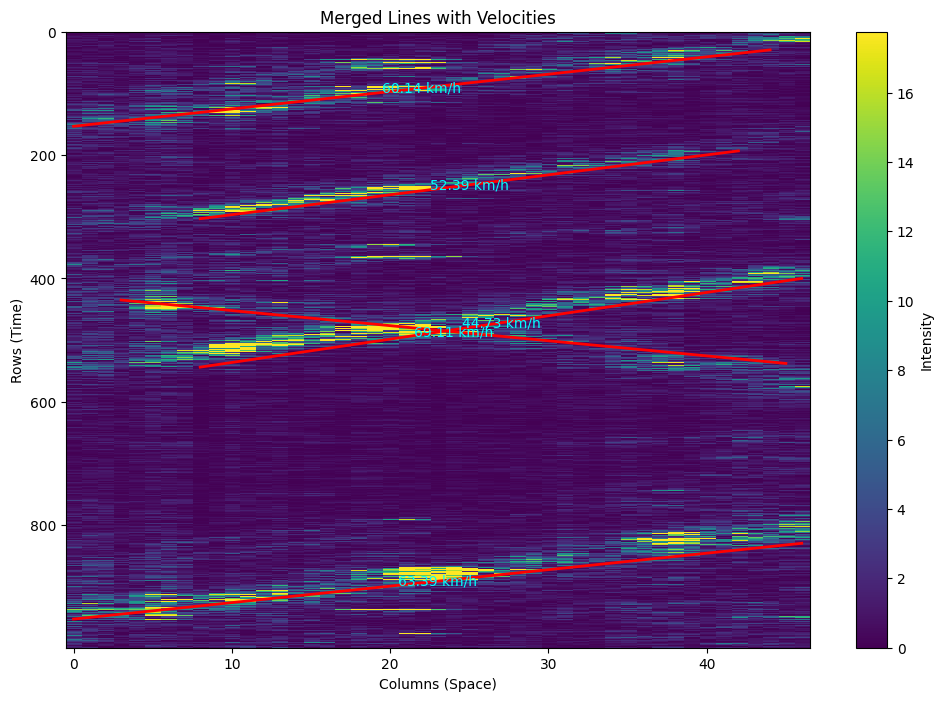

In [24]:
plot_image(df_orginal, a=12,b=8,lines=merged_lines, title="Merged Lines with Velocities",velocities=velocities)